In [15]:
import matplotlib.pyplot as plt
from datetime import datetime
from xgboost import XGBRanker
import lightgbm
from tqdm import tqdm
import pandas as pd
import numpy as np

In [3]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


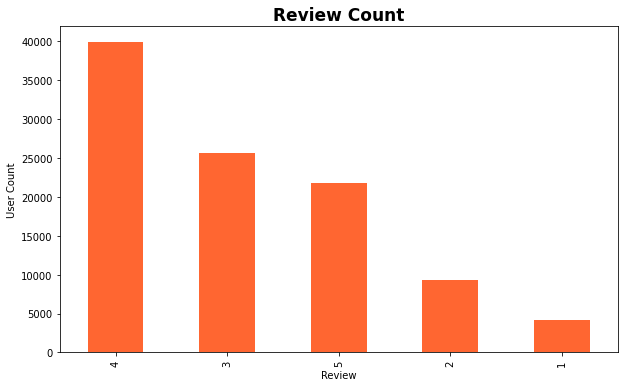

In [4]:
ratings.rating.apply(lambda x:int(np.ceil(x))).value_counts().plot.bar(figsize=(10,6), color='#FF6631')
plt.title('Review Count', fontweight='bold', fontsize=17)
plt.xlabel('Review')
plt.ylabel('User Count')
plt.show()

count                           100836
mean     2008-03-19 11:38:29.860436480
min                1996-03-29 12:36:55
25%                2002-04-18 04:57:46
50%                2007-08-02 15:31:02
75%         2015-07-04 02:15:44.500000
max                2018-09-24 09:27:30
Name: timestamp, dtype: object


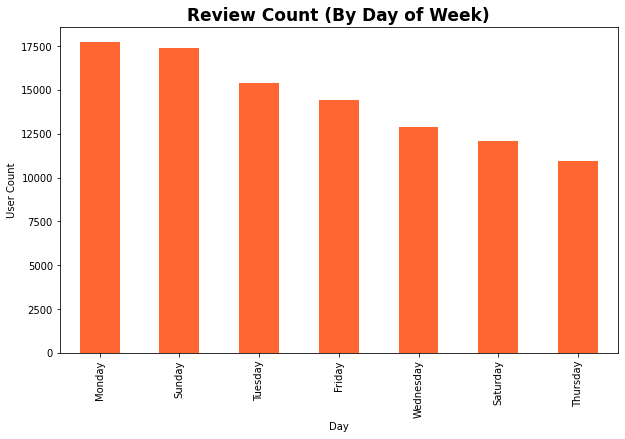

In [5]:
ratings['timestamp'] = ratings['timestamp'].map(lambda x: datetime.fromtimestamp(x))
print(ratings['timestamp'].describe(datetime_is_numeric=True))


ratings['timestamp'].dt.day_name().value_counts().plot.bar(color='#FF6631', figsize=(10,6))
plt.title('Review Count (By Day of Week)', fontweight='bold', fontsize=17)
plt.xlabel('Day')
plt.ylabel('User Count')
plt.show()

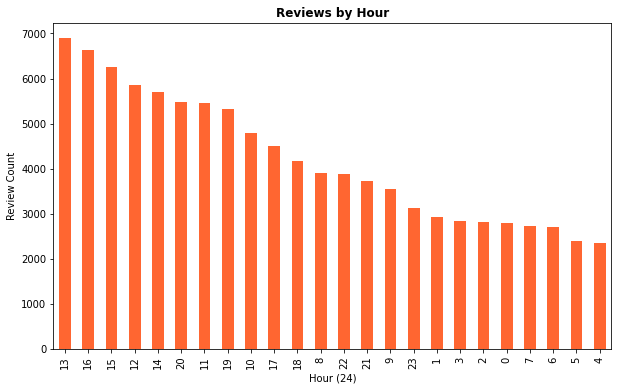

In [6]:
ratings.timestamp.dt.hour.value_counts().plot.bar(figsize=(10,6), color='#FF6631')
plt.xlabel('Hour (24)')
plt.ylabel('Review Count')
plt.title('Reviews by Hour', fontweight='bold')
plt.show()

In [7]:
def get_feature_by_user(df):
    res = list()
    for i, v in tqdm(df.groupby('userId')):
        res.append(
            (
                i,
                len(v['movieId']),
                (v['rating'] == 5).sum(),
                (v['rating'] == 4).sum(),
                (v['rating'] == 3).sum(),
                (v['rating'] == 2).sum(),
                (v['rating'] == 1).sum(),
                (v['timestamp'].dt.dayofweek == 0).sum(),
                (v['timestamp'].dt.dayofweek == 1).sum(),
                (v['timestamp'].dt.dayofweek == 2).sum(),
                (v['timestamp'].dt.dayofweek == 3).sum(),
                (v['timestamp'].dt.dayofweek == 4).sum(),
                (v['timestamp'].dt.dayofweek == 5).sum(),
                (v['timestamp'].dt.dayofweek == 6).sum(),
                (v['timestamp'].dt.hour > 17).sum()

            )
        )
    
    res = pd.DataFrame(
        res,
        columns=[
            'userId', 'revired_products', '5_star_ratings_gave', '4_star_ratings_gave',
            '3_star_ratings_gave', '2_star_ratings_gave', '1_star_ratings_gave',
            'monday_review_count_user', 'tuesday_review_count_user', 'wednesday_review_count_user', 'thursday_review_count_user',
            'friday_review_count_user', 'saturday_review_count_user', 'sunday_review_count_user','evening_reviews_by_user'
        ])
    return res
   
def get_feature_by_product(df):
    res = list()
    for i, v in tqdm(df.groupby('movieId')):
        res.append(
            (
                i,
                len(v['userId']),
                (v['rating'] == 5).sum(),
                (v['rating'] == 4).sum(),
                (v['rating'] == 3).sum(),
                (v['rating'] == 2).sum(),
                (v['rating'] == 1).sum(),
                (v['timestamp'].dt.dayofweek == 0).sum(),
                (v['timestamp'].dt.dayofweek == 1).sum(),
                (v['timestamp'].dt.dayofweek == 2).sum(),
                (v['timestamp'].dt.dayofweek == 3).sum(),
                (v['timestamp'].dt.dayofweek == 4).sum(),
                (v['timestamp'].dt.dayofweek == 5).sum(),
                (v['timestamp'].dt.dayofweek == 6).sum(),
                (v['timestamp'].dt.hour > 17).sum()
            )
        )
    
    res = pd.DataFrame(
        res,
        columns=[
            'movieId', 'user_count', '1_star_ratings_recieved', '2_star_ratings_recieved',
            '3_star_ratings_recieved', '4_star_ratings_recieved', '5_star_ratings_recieved',
            'monday_review_count_item', 'tuesday_review_count_item', 'wednesday_review_count_item', 'thursday_review_count_item',
            'friday_review_count_item', 'saturday_review_count_item', 'sunday_review_count_item','evening_reviews_by_movie'
        ])
    return res

In [8]:
start = min(ratings['timestamp'])
end = max(ratings['timestamp'])
interval = end - start

ratings['rating'] = ratings['rating'].apply(lambda x:int(np.ceil(x)))

train = ratings[ratings['timestamp'] <= (end - interval/3)]
test = ratings[ratings['timestamp'] >= (start + interval/3)]

train_y = train[train['timestamp'] >= (start + interval/3)]
train_X = train[train['timestamp'] < (start + interval/3)]
test_y = test[test['timestamp'] >= (end - interval/3)]
test_X = test[test['timestamp'] < (end - interval/3)]

train_tgt_user = set(train_X['userId']) & set(train_y['userId'])
test_tgt_user = set(test_X['userId']) & set(test_y['userId'])

f"""train_X.shape: {train_X.shape} test_X.shape: {test_X.shape}"""

'train_X.shape: (31958, 4) test_X.shape: (31833, 4)'

In [9]:
test.timestamp.min(),test.timestamp.max()

(Timestamp('2003-09-27 11:52:42'), Timestamp('2018-09-24 09:27:30'))

In [10]:
train.timestamp.min(),train.timestamp.max()

(Timestamp('1996-03-29 12:36:55'), Timestamp('2011-03-26 18:42:37'))

In [11]:
train_X_u = get_feature_by_user(train_X)
test_X_u = get_feature_by_user(test_X)

train_X_p = get_feature_by_product(train_X)
test_X_p = get_feature_by_product(test_X)

100%|██████████████████████████████████████| 5418/5418 [00:22<00:00, 243.01it/s]


In [12]:
def get_model_input(X_u, X_m, y, tgt_users):

    merged = pd.merge(X_u, y, on=['userId'], how='inner')
    merged = pd.merge(X_m, merged, on=['movieId'], how='outer')
    merged = merged.query('userId in @tgt_users')
    # print(merged.columns)

    merged.fillna(0, inplace=True)
    features_cols = list(merged.drop(columns=['userId', 'movieId', 'rating', 'timestamp']).columns)

    query_list = merged['userId'].value_counts()

    merged = merged.set_index(['userId', 'movieId'])

    query_list = query_list.sort_index()

    merged.sort_index(inplace=True)

    df_x = merged[features_cols]

    df_y = merged['rating']
    
    return df_x, df_y, query_list

X_train, y_train, query_list_train = get_model_input(train_X_u, train_X_p, train_y, train_tgt_user)
X_test, y_test, query_list_test = get_model_input(test_X_u, test_X_p, test_y, test_tgt_user)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [16]:
model = XGBRanker(objective='rank:ndcg', n_estimators=100, random_state=0,learning_rate=0.1)
model.fit(
    X_train,
    y_train,
    group=query_list_train,
    eval_metric='ndcg',
    eval_set=[(X_test, y_test)],
    eval_group=[list(query_list_test)],
    verbose =10
)

[0]	validation_0-ndcg:0.87009
[10]	validation_0-ndcg:0.87478
[20]	validation_0-ndcg:0.86852
[30]	validation_0-ndcg:0.86990
[40]	validation_0-ndcg:0.87104
[50]	validation_0-ndcg:0.87756


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-ndcg:0.88578
[70]	validation_0-ndcg:0.88352
[80]	validation_0-ndcg:0.88374
[90]	validation_0-ndcg:0.88492
[99]	validation_0-ndcg:0.88482


XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=None,
          enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.1, max_bin=256,
          max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
          min_child_weight=1, missing=nan, monotone_constraints='()',
          n_estimators=100, n_jobs=0, num_parallel_tree=1,
          objective='rank:ndcg', predictor='auto', random_state=0, reg_alpha=0, ...)

In [17]:
query_list_train.shape

(17,)

In [18]:
len(np.unique(X_train.index.get_level_values(0).values))

17

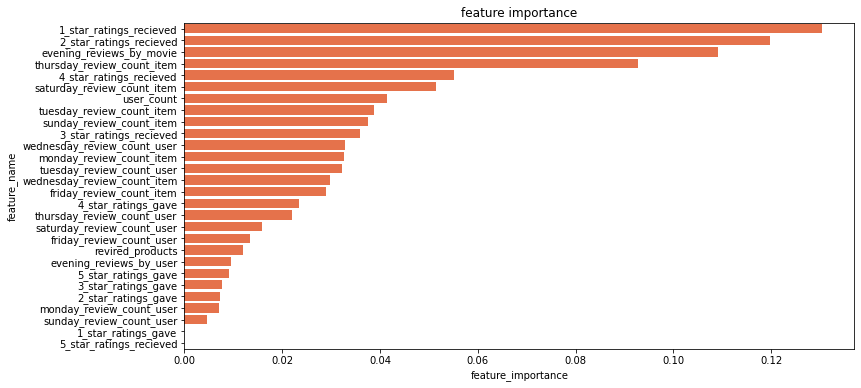

In [21]:
import seaborn as sns
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame({'feature_name': X_train.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt,color='#FF6631')
plt.title('feature importance')
plt.show()

In [39]:
def predict_at_k(data, model, k):
    user_ids = list()
    product_ids = list()
    ranks = list()
    
    for userId, df in data.groupby('userId'):
        
        pred = model.predict(df.loc[userId])
        productId = np.array(df.reset_index()['movieId'])
        topK_index = np.argsort(pred)[::-1][:k]
        product_ids.extend(list(productId[topK_index]))
        user_ids.extend([userId]*len(topK_index))
        ranks.extend(list(range(1, len(topK_index)+1)))

    results = pd.DataFrame({'userId': user_ids, 'movieId': product_ids, 'rank': ranks})
    
    return results

predicted = predict_at_k(X_test, model, 5)

In [40]:
predicted

,userId,movieId,rank
0,15.0,70286,1
1,15.0,3535,2
2,15.0,58559,3
3,15.0,59315,4
4,15.0,293,5
...,...,...,...
89,606.0,72998,1
90,606.0,592,2
91,606.0,1,3
92,606.0,33615,4


In [41]:
sample = 15.0
print('[predicted]')
print(predicted.query(f'userId == {sample}')[['movieId', 'rank']])
print('+'*20)
print('[actual]')
print(y_test[sample].sort_values(ascending=False))

[predicted]
   movieId  rank
0    70286     1
1     3535     2
2    58559     3
3    59315     4
4      293     5
++++++++++++++++++++
[actual]
movieId
5989      5.0
48304     5.0
1270      5.0
4720      5.0
1653      5.0
         ... 
2085      2.0
91529     2.0
5971      2.0
122924    1.0
99114     1.0
Name: rating, Length: 119, dtype: float64


In [42]:
def coverage(preds,train_X_p):
  test_recs = preds['movieId'].nunique()
  train_movies = train_X_p['movieId'].nunique()

  return test_recs/train_movies

In [43]:
coverage(predicted,train_X_p)

0.021021820117083555